<h2 align=center> Facial Expression Recognition with Keras</h2>

### Task 1: Import Libraries

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.10.1


In [6]:
tf.config.list_physical_devices('GPU')

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### Task 2: Plot Sample Image

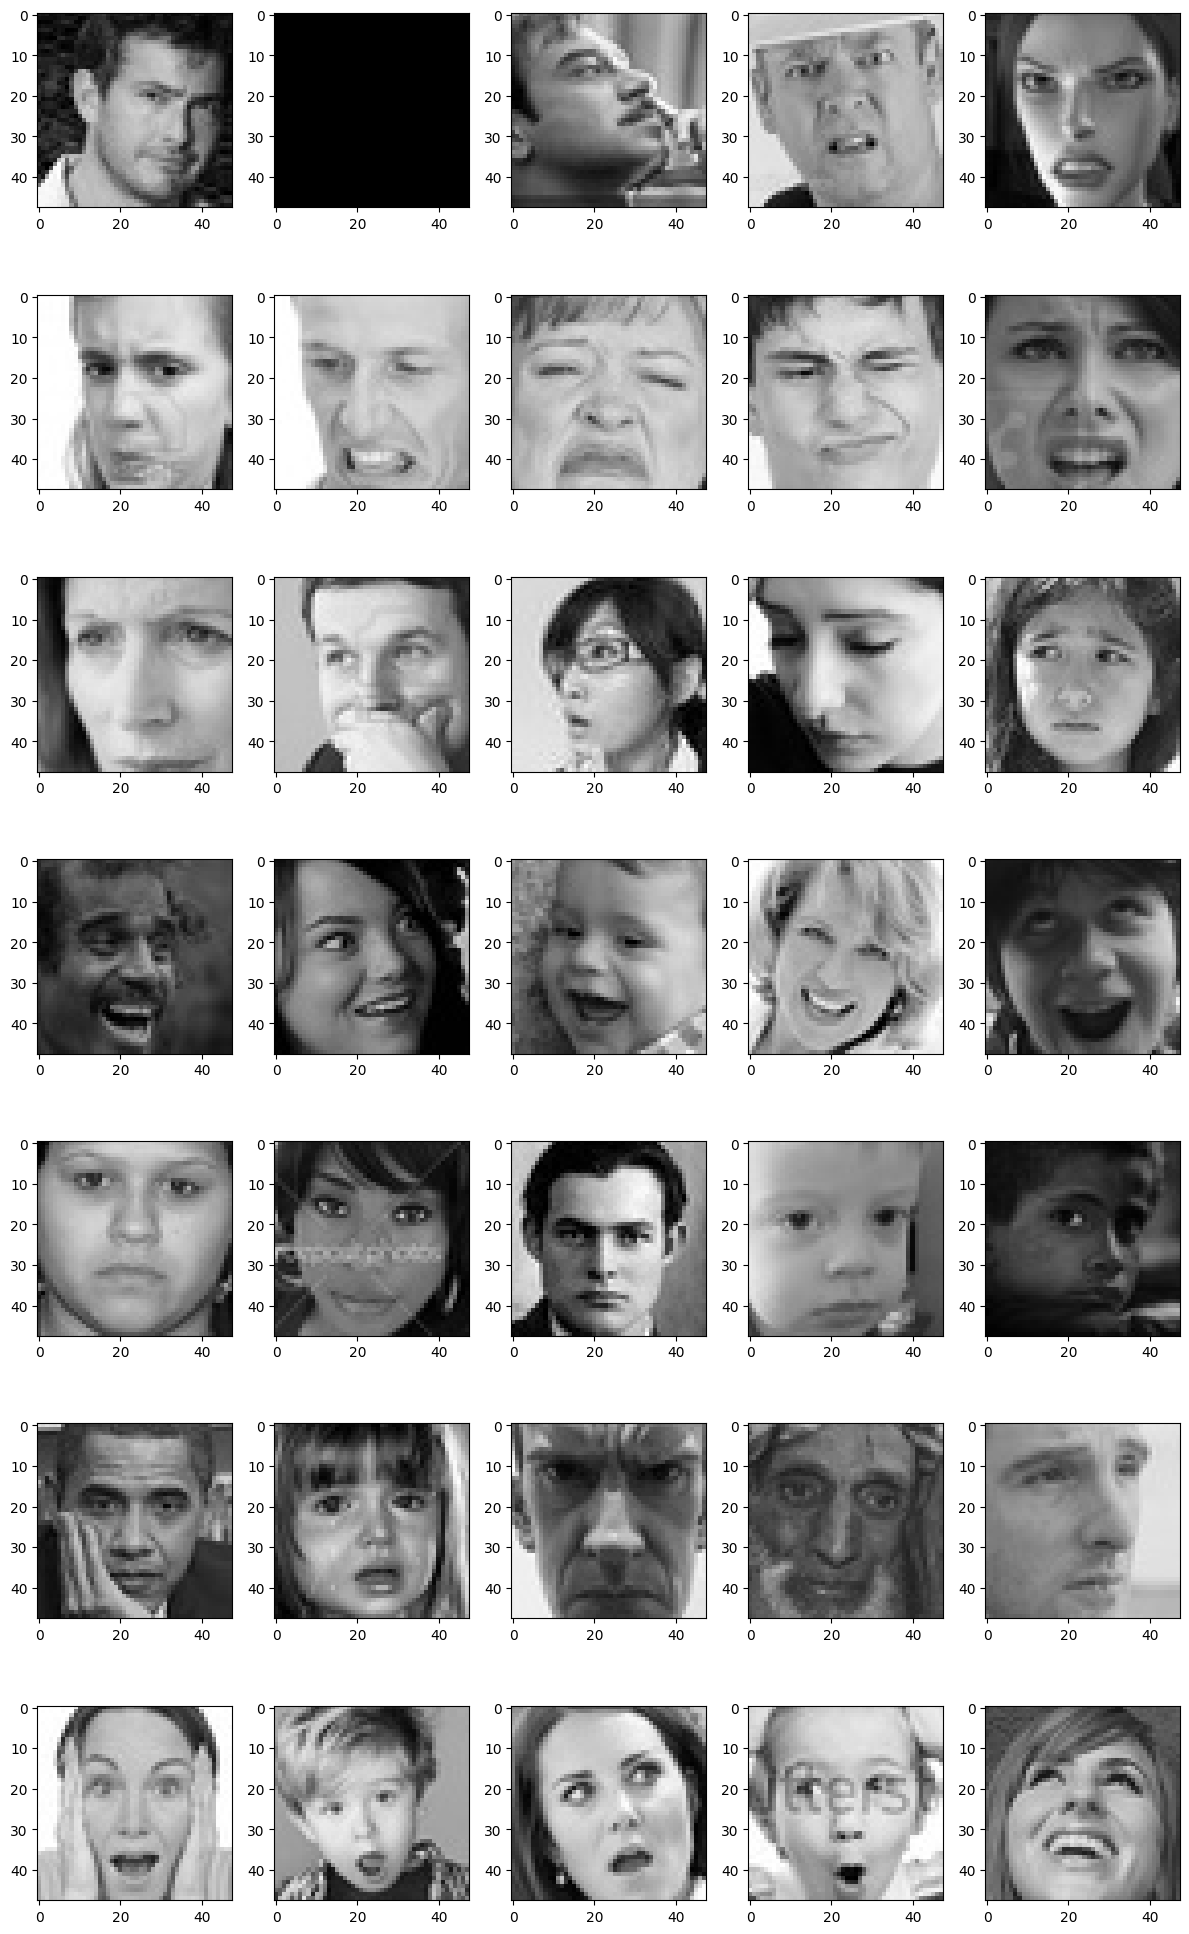

In [7]:
utils.datasets.fer.plot_example_images(plt).show()

In [8]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/"+expression)))+ " " + expression + "images")

3995 angryimages
436 disgustimages
4097 fearimages
7215 happyimages
4965 neutralimages
4830 sadimages
3171 surpriseimages


### Task 3: Generate Training and Validation Batches

In [9]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip = True)
train_generator = datagen_train.flow_from_directory("train/", target_size = (img_size,img_size),
                                                    color_mode = 'grayscale',
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip = True)
validation_generator = datagen_train.flow_from_directory("test/", target_size = (img_size,img_size),
                                                    color_mode = 'grayscale',
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Task 4: Create CNN Model

![](model.png)
Inspired by Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. *Neural Networks*, 64, 59-63. [doi:10.1016/j.neunet.2014.09.005](https://arxiv.org/pdf/1307.0414.pdf)

In [22]:
model =Sequential()

# 1 - conv
model.add(Conv2D(64, (3,3), padding = 'same', input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2 - conv
model.add(Conv2D(128, (5,5), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3 - conv
model.add(Conv2D(512, (3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 4 - conv
model.add(Conv2D(512, (3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation = 'softmax'))
opt = Adam(learning_rate = 0.0005)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_16 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 128)      

### Task 6: Train and Evaluate Model

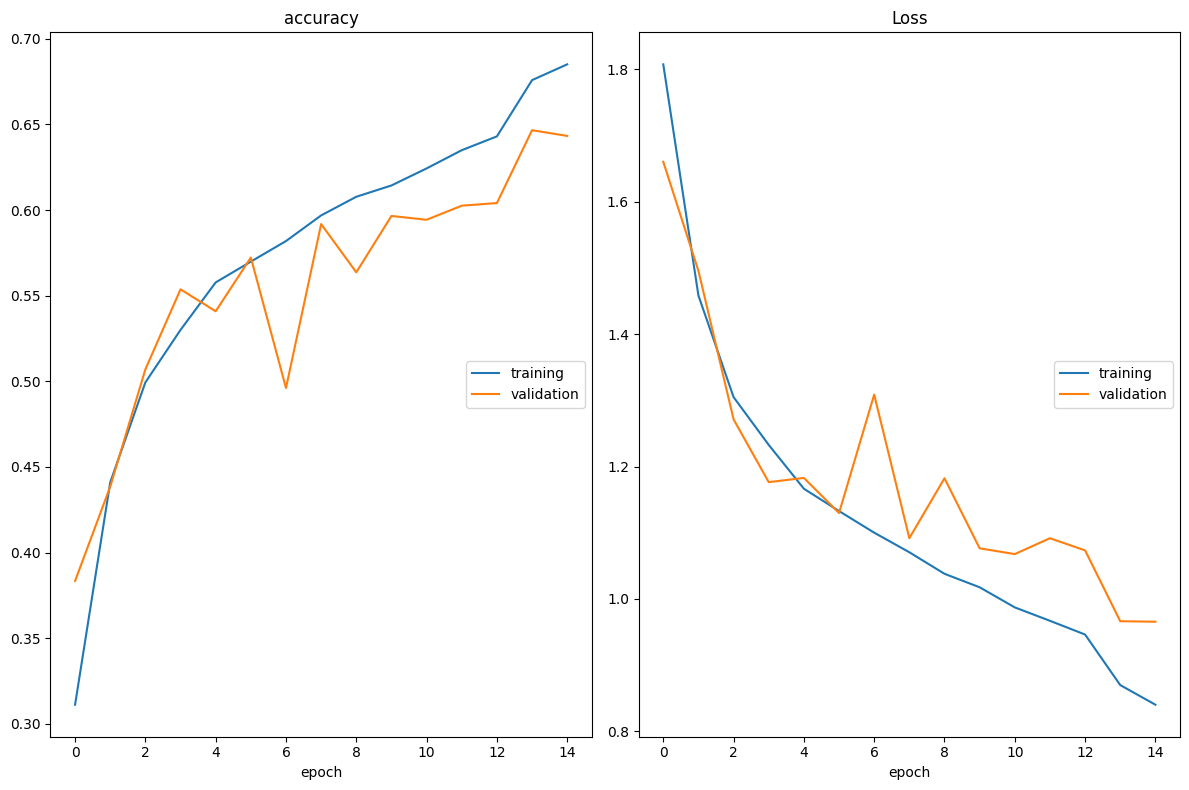

accuracy
	training         	 (min:    0.311, max:    0.685, cur:    0.685)
	validation       	 (min:    0.383, max:    0.647, cur:    0.643)
Loss
	training         	 (min:    0.840, max:    1.808, cur:    0.840)
	validation       	 (min:    0.966, max:    1.660, cur:    0.966)

Epoch 15: saving model to model_weight.h5
448/448 [==============================] - 93s 208ms/step - loss: 0.8402 - accuracy: 0.6851 - val_loss: 0.9655 - val_accuracy: 0.6433 - lr: 5.0000e-05


In [29]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weight.h5", monitor = 'val_accuracy',
                             save_weights_only = True, mode = 'max', verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 0.00001, model = 'auto')

callbacks = [PlotLossesKeras(),checkpoint, reduce_lr]

history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks
)

### Task 7: Represent Model as JSON String

In [31]:
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)